In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]
density_path = r"C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\Average_Household_Size_and_Population_Density_-_County.csv"
density = pd.read_csv(density_path)
density = density[["GEOID", "B01001_calc_PopDensity"]]
nielsen = pd.merge(nielsen, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')
nielsen = nielsen.rename(columns={"B01001_calc_PopDensity": "Population density (people/km^2)"})

## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stillremain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
nielsen = nielsen[~np.isin(nielsen.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
#movements['year'] = movements.Opening_date.dt.year
#movements['month'] = movements.Opening_date.dt.month

In [3]:
#nielsen.groupby('product_group_descr').mean().sort_values('upc_price_std', ascending=True).head(30)

In [4]:
categories = [
    "FRESH PRODUCE",
    "BREAD AND BAKED GOODS",
    "MILK",
    "SNACKS",
    "PACKAGED MEATS-DELI",
    "CHEESE",
    "UNPREP MEAT/POULTRY/SEAFOOD-FRZN",
    "CARBONATED BEVERAGES",
    "CONDIMENTS, GRAVIES, AND SAUCES",
    "CANDY",
    "JUICE, DRINKS - CANNED, BOTTLED",
    "EGGS",
    "CEREAL",
    "PASTA",
    "COT CHEESE, SOUR CREAM, TOPPINGS",
    "PAPER PRODUCTS",
    "YOGURT"
]
state_for_cat = {"FRESH PRODUCE" : "FL",
    "BREAD AND BAKED GOODS" : "FL",
    "MILK" : "FL",
    "SNACKS" : "FL",
    "PACKAGED MEATS-DELI" : "FL",
    "CHEESE" : "FL",
    "UNPREP MEAT/POULTRY/SEAFOOD-FRZN" : "FL",
    "CARBONATED BEVERAGES" : "FL",
    "CONDIMENTS, GRAVIES, AND SAUCES" : "FL",
    "CANDY" : "FL",
    "JUICE, DRINKS - CANNED, BOTTLED" : "FL",
    "EGGS" : "FL",
    "CEREAL" : "FL",
    "PASTA" : "FL"}

## Building a better control group

In [5]:
# Selection of a promising (state, category), that is, statisticaly significant 
# interaction term for the model with time fixed effects, and a pattern that makes sense to us (negative term)
state = "SC"
category = "JUICE, DRINKS - CANNED, BOTTLED"
# coeff/stde = 2.9, coeff = -0.12

In [6]:
#for state in states :
    # 
product_group = nielsen[(nielsen.product_group_descr == category)&(nielsen.store_state == state)
                       ]
    # The control group is composed by all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()

# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')

# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
control['time_effects'] = list(zip(control.purchase_year, control.purchase_month))

treatment['treat'] = True
treatment['interaction'] = (((treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year == treatment.Opening_date.dt.year))|
                           (treatment.purchase_year > treatment.Opening_date.dt.year))
treatment['time_effects'] = list(zip(treatment.purchase_year, treatment.purchase_month))


# Final dataset for the regression :q

df0 = pd.concat((control, treatment))
df = df0[['upc_price', 'treat', 'interaction','time_effects']]
df = df[df.upc_price != 0]
reg0 = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(time_effects)', data=df)
results0 = reg0.fit()

if abs(results0.params[2] / results0.bse[2]) > 0. :
    print("=========================================================")
 #   print(state)
    print(f"Coef : {np.exp(results0.params[2])-1}")
    print(f"Coef/err : {abs(results0.params[2] / results0.bse[2])}")
    print(f"CI_up : {np.exp(results0.conf_int(alpha=0.05)[0][2])-1}")
    print(f"CI_down : {np.exp(results0.conf_int(alpha=0.05)[1][2])-1}")

Coef : -0.11738860482349478
Coef/err : 2.8600455319055946
CI_up : -0.18990572510747739
CI_down : -0.03837997744303334


In [7]:
results0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.898
Date:                Mon, 07 Nov 2022   Prob (F-statistic):            0.00547
Time:                        22:10:56   Log-Likelihood:                -109.97
No. Observations:                 667   AIC:                             271.9
Df Residuals:                     641   BIC:                             389.0
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.9551      0.057     16.781      0.000       0.843       1.067
treat[T.True]                     0.0167      0.030      0.552      0.581      -0.043       0.076
interaction[T.True]              -0.1249      0.044     -2.860      0.004      -0.211      -0.039
C(time_effects)[T.(2015, 2)]      0.0151      0.077      0.195      0.845      -0.137       0.167
C(time_effects)[T.(2015, 3)]     -0.0113      0.079     -0.144      0.886      -0.165       0.143
C(time_effects)[T.(2015, 4)]     -0.0860      0.081     -1.065      0.287      -0.245       0.073
C(time_effects)[T.(2015, 5)]     -0.0338      0.079     -0.431      0.667      -0.188       0.120
C(time_effects)[T.(2015, 6)]     -0.0333      0.079     -0.424      0.672      -0.187       0.121
C(time_effects)[T.(2015, 7)]     -0.1043      0.078     -1.340      0.181      -0.257       0.049
C(time_effects)[T.(2015, 8)]     -0.1389      0.077     -1.796      0.073      -0.291       0.013
C(time_effects)[T.(2015, 9)]     -0.1329      0.080     -1.660      0.097      -0.290       0.024
C(time_effects)[T.(2015, 10)]    -0.0242      0.080     -0.303      0.762      -0.181       0.133
C(time_effects)[T.(2015, 11)]    -0.0003      0.078     -0.004      0.997      -0.153       0.153
C(time_effects)[T.(2015, 12)]     0.0933      0.080      1.165      0.245      -0.064       0.251
C(time_effects)[T.(2016, 1)]      0.0717      0.079      0.911      0.363      -0.083       0.226
C(time_effects)[T.(2016, 2)]      0.0606      0.079      0.762      0.446      -0.095       0.217
C(time_effects)[T.(2016, 3)]      0.0249      0.079      0.317      0.752      -0.130       0.180
C(time_effects)[T.(2016, 4)]     -0.0459      0.080     -0.571      0.568      -0.204       0.112
C(time_effects)[T.(2016, 5)]     -0.0293      0.078     -0.374      0.709      -0.183       0.125
C(time_effects)[T.(2016, 6)]      0.0249      0.079      0.317      0.751      -0.129       0.179
C(time_effects)[T.(2016, 7)]     -0.1149      0.080     -1.445      0.149      -0.271       0.041
C(time_effects)[T.(2016, 8)]     -0.1697      0.078     -2.171      0.030      -0.323      -0.016
C(time_effects)[T.(2016, 9)]     -0.0497      0.080     -0.625      0.532      -0.206       0.106
C(time_effects)[T.(2016, 10)]    -0.0244      0.079     -0.309      0.757      -0.179       0.130
C(time_effects)[T.(2016, 11)]    -0.0280      0.080     -0.348      0.728      -0.186       0.130
C(time_effects)[T.(2016, 12)]     0.0176      0.081      0.217      0.828      -0.142       0.177
==============================================================================
Omnibus:                       34.466   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.520
Skew

In [8]:
y_hat = results0.fittedvalues
u_hat = results0.resid
y_hat = y_hat.rename("fitted_value").to_frame()
u_hat = u_hat.rename("residual").to_frame()

In [9]:
new0 = pd.merge(df0, y_hat, left_index=True, right_index=True)
new = pd.merge(new0, u_hat, left_index=True, right_index=True)
new['date']=new['purchase_month']+12*(new['purchase_year']-2015)
new['fitted_value']=np.exp(new['fitted_value'])-1
new['residual']= new['upc_price']-new['fitted_value']
new['s_residual']=new['residual']**2
new = new[['upc_price', 'nb_of_obs', 
       'Population density (people/km^2)', 'treat',
       'interaction', 'time_effects', 'store_state', 'guessed_store_county',
       'guessed_store_county_fips',
       'Opening_date', 'Closing_date', 'fitted_value', 'residual', 'date', 's_residual']]

In [10]:
new_t = new[new.treat]
new_c = new[~new.treat]
new_t_i = new_t[new_t.interaction]
new_t_ni = new_t[~new_t.interaction]

### 1. Nb of counties in control and treatment groups, density distribution

8.71753759395985 166.025133721354


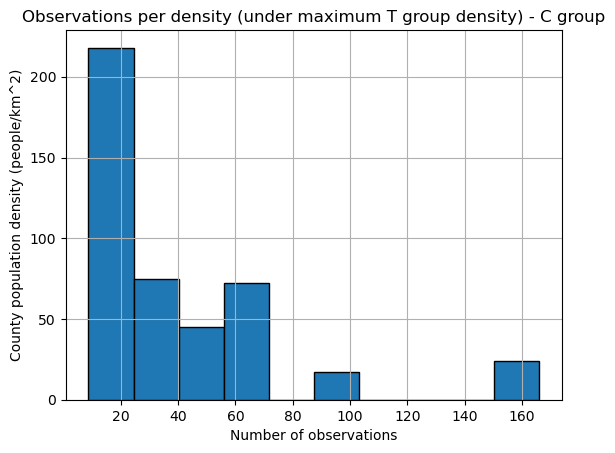

In [11]:
print(control["Population density (people/km^2)"].min(),control["Population density (people/km^2)"].max())
plt.hist(control["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

In [12]:
#control group analysis
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")
print(f"Size of the control group: {control.guessed_store_county_fips.count()}.")
control_d = control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()

Size of the control group: 27.
Size of the control group: 451.


C:\Users\inesn\AppData\Local\Temp\ipykernel_37980\2391365913.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  control_d = control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


In [13]:
control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).count().head(50)

is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45001                     ABBEVILLE                     16   
            45003                     AIKEN                         24   
            45005                     ALLENDALE                      3   
            45009                     BAMBERG                       10   
            45011                     BARNWELL                       1   
            45017                     CALHOUN                       24   
            45019                     CHARLESTON                    24   
            45021                     CHEROKEE                      21   
            45023                     CHESTER                       19   
            45025                     CHESTERFIELD                  23   
            45027                     CLARENDON                      3   
            45029                     COLLETON                       9   
            45033                     DILLON                         9   
            45041                     FLORENCE                      24   
            45049                     HAMPTON                       19   
            45053                     JASPER                        14   
            45055                     KERSHAW                       24   
            45057                     LANCASTER                     24   
            45067                     MARION                        18   
            45069                     MARLBORO                      22   
            45071                     NEWBERRY                      24   
            45073                     OCONEE                        24   
            45075                     ORANGEBURG                    24   
            45077                     PICKENS                       17   
            45081                     SALUDA                         6   
            45087                     UNION                          3   
            45089                     WILLIAMSBURG                  22   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45001                     ABBEVILLE                        16   
            45003                     AIKEN                            24   
            45005                     ALLENDALE                         3   
            45009                     BAMBERG                          10   
            45011                     BARNWELL                          1   
            45017                     CALHOUN                          24   
            45019                     CHARLESTON                       24   
            45021                     CHEROKEE                         21   
            45023                     CHESTER                          19   
            45025                     CHESTERFIELD                     23   
            45027                     CLARENDON                         3   
            45029                     COLLETON                          9   
            45033                     DILLON                            9   
            45041                     FLORENCE                         24   
            45049                     HAMPTON                          19   
            45053                     JASPER                           14   
            45055                     KERSHAW                          24   
            45057                     LANCASTER                        24   
            45067                     MARION                           18   
            45069                     MARLBORO                         22   
            45071                     NEWBERRY                         24   
            45073                     OCONEE                           24   
            45075                     ORANGEBURG                 

In [14]:
control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)

C:\Users\inesn\AppData\Local\Temp\ipykernel_37980\462922393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)


is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45001                     ABBEVILLE                    0.0   
            45003                     AIKEN                        0.0   
            45005                     ALLENDALE                    0.0   
            45009                     BAMBERG                      0.0   
            45011                     BARNWELL                     0.0   
            45017                     CALHOUN                      0.0   
            45019                     CHARLESTON                   0.0   
            45021                     CHEROKEE                     0.0   
            45023                     CHESTER                      0.0   
            45025                     CHESTERFIELD                 0.0   
            45027                     CLARENDON                    0.0   
            45029                     COLLETON                     0.0   
            45033                     DILLON                       0.0   
            45041                     FLORENCE                     0.0   
            45049                     HAMPTON                      0.0   
            45053                     JASPER                       0.0   
            45055                     KERSHAW                      0.0   
            45057                     LANCASTER                    0.0   
            45067                     MARION                       0.0   
            45069                     MARLBORO                     0.0   
            45071                     NEWBERRY                     0.0   
            45073                     OCONEE                       0.0   
            45075                     ORANGEBURG                   0.0   
            45077                     PICKENS                      0.0   
            45081                     SALUDA                       0.0   
            45087                     UNION                        0.0   
            45089                     WILLIAMSBURG                 0.0   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45001                     ABBEVILLE               2015.625000   
            45003                     AIKEN                   2015.500000   
            45005                     ALLENDALE               2016.000000   
            45009                     BAMBERG                 2015.000000   
            45011                     BARNWELL                2016.000000   
            45017                     CALHOUN                 2015.500000   
            45019                     CHARLESTON              2015.500000   
            45021                     CHEROKEE                2015.476190   
            45023                     CHESTER                 2015.631579   
            45025                     CHESTERFIELD            2015.521739   
            45027                     CLARENDON               2015.666667   
            45029                     COLLETON                2015.000000   
            45033                     DILLON                  2016.000000   
            45041                     FLORENCE                2015.500000   
            45049                     HAMPTON                 2015.473684   
            45053                     JASPER                  2015.500000   
            45055                     KERSHAW                 2015.500000   
            45057                     LANCASTER               2015.500000   
            45067                     MARION                  2015.444444   
            45069                     MARLBORO                2015.545455   
            45071                     NEWBERRY                2015.500000   
            45073                     OCONEE                  2015.500000   
            45075                     ORANGEBURG              201

8.71753759395985 166.025133721354


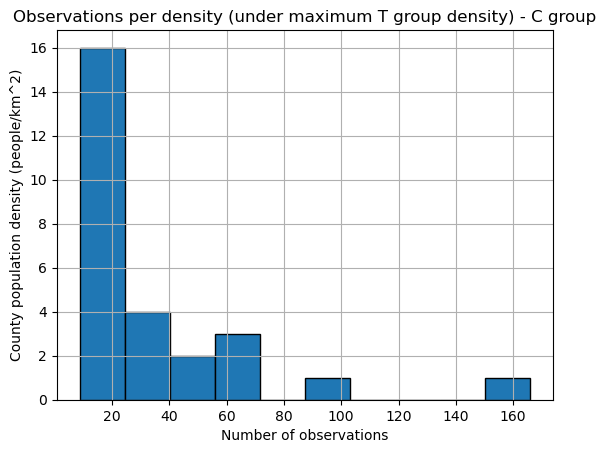

In [15]:
print(control_d["Population density (people/km^2)"].min(),control_d["Population density (people/km^2)"].max())
plt.hist(control_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

In [16]:
# treatment group analysis
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {treatment.guessed_store_county_fips.count()}.")
treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()

Size of the treatment group: 9.
Size of the treatment group: 216.


C:\Users\inesn\AppData\Local\Temp\ipykernel_37980\3664718350.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


In [17]:
treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).count().head(50)

is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45007                     ANDERSON                      24   
            45013                     BEAUFORT                      24   
            45031                     DARLINGTON                    24   
            45043                     GEORGETOWN                    24   
            45045                     GREENVILLE                    24   
            45047                     GREENWOOD                     24   
            45063                     LEXINGTON                     24   
            45085                     SUMTER                        24   
            45091                     YORK                          24   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45007                     ANDERSON                         24   
            45013                     BEAUFORT                         24   
            45031                     DARLINGTON                       24   
            45043                     GEORGETOWN                       24   
            45045                     GREENVILLE                       24   
            45047                     GREENWOOD                        24   
            45063                     LEXINGTON                        24   
            45085                     SUMTER                           24   
            45091                     YORK                             24   

                                                            purchase_month  \
store_state guessed_store_county_fips guessed_store_county                   
SC          45007                     ANDERSON                          24   
            45013                     BEAUFORT                          24   
            45031                     DARLINGTON                        24   
            45043                     GEORGETOWN                        24   
            45045                     GREENVILLE                        24   
            45047                     GREENWOOD                         24   
            45063                     LEXINGTON                         24   
            45085                     SUMTER                            24   
            45091                     YORK                              24   

                                                            product_group_descr  \
store_state guessed_store_county_fips guessed_store_county                        
SC          45007                     ANDERSON                               24   
            45013                     BEAUFORT                               24   
            45031                     DARLINGTON                             24   
            45043                     GEORGETOWN                             24   
            45045                     GREENVILLE                             24   
            45047                     GREENWOOD                              24   
            45063                     LEXINGTON                              24   
            45085                     SUMTER                                 24   
            45091                     YORK                                   24   

                                                            upc_price  \
store_state guessed_store_county_fips guessed_store_county              
SC          45007                     ANDERSON                     24   
            45013                     BEAUFORT                     24   
            45031                     DARLINGTON                   24   
            45043                     GEORGETOWN                   24   
            45045                     GREENVILLE                   24   
            45047                     GREENWOOD                    24   
            45063                     LE

In [18]:
treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)

C:\Users\inesn\AppData\Local\Temp\ipykernel_37980\4114228560.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)


is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45007                     ANDERSON                     0.0   
            45013                     BEAUFORT                     0.0   
            45031                     DARLINGTON                   0.0   
            45043                     GEORGETOWN                   0.0   
            45045                     GREENVILLE                   0.0   
            45047                     GREENWOOD                    0.0   
            45063                     LEXINGTON                    0.0   
            45085                     SUMTER                       0.0   
            45091                     YORK                         0.0   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45007                     ANDERSON                     2015.5   
            45013                     BEAUFORT                     2015.5   
            45031                     DARLINGTON                   2015.5   
            45043                     GEORGETOWN                   2015.5   
            45045                     GREENVILLE                   2015.5   
            45047                     GREENWOOD                    2015.5   
            45063                     LEXINGTON                    2015.5   
            45085                     SUMTER                       2015.5   
            45091                     YORK                         2015.5   

                                                            purchase_month  \
store_state guessed_store_county_fips guessed_store_county                   
SC          45007                     ANDERSON                         6.5   
            45013                     BEAUFORT                         6.5   
            45031                     DARLINGTON                       6.5   
            45043                     GEORGETOWN                       6.5   
            45045                     GREENVILLE                       6.5   
            45047                     GREENWOOD                        6.5   
            45063                     LEXINGTON                        6.5   
            45085                     SUMTER                           6.5   
            45091                     YORK                             6.5   

                                                            upc_price  \
store_state guessed_store_county_fips guessed_store_county              
SC          45007                     ANDERSON               1.956022   
            45013                     BEAUFORT               2.955224   
            45031                     DARLINGTON             2.391708   
            45043                     GEORGETOWN             2.818515   
            45045                     GREENVILLE             2.572343   
            45047                     GREENWOOD              1.772099   
            45063                     LEXINGTON              2.619889   
            45085                     SUMTER                 2.676915   
            45091                     YORK                   2.783321   

                                                            upc_price_std  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45007                     ANDERSON                   1.216264   
            45013                     BEAUFORT                   1.268212   
            45031                     DARLINGTON                 0.864510   
            45043                     GEORGETOWN                 1.523599   
            45045                     GREENVILLE                 1.585044   
            45047                     GREENWOOD                  1.119051   
            45063                     LEXINGTON                  1.295670   
            45085                     SUM

29.2250338775805 245.119501334035


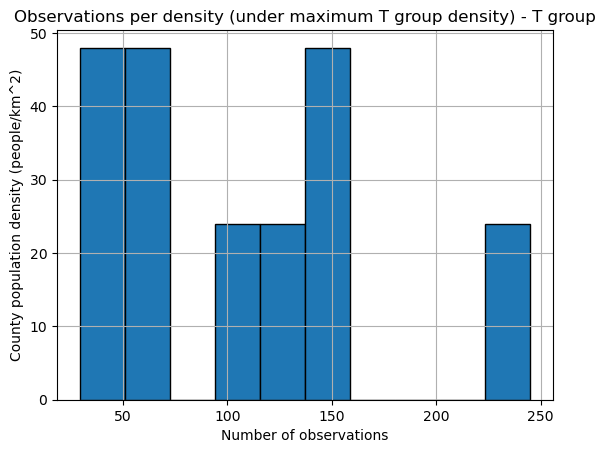

In [19]:
print(treatment["Population density (people/km^2)"].min(),treatment["Population density (people/km^2)"].max())
plt.hist(treatment["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

29.2250338775805 245.119501334035


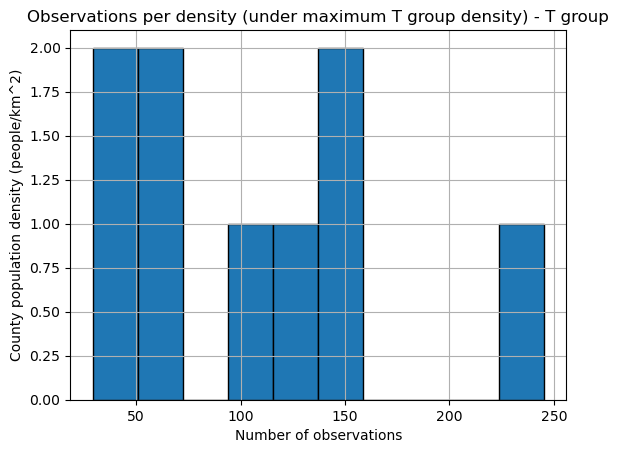

In [20]:
print(treatment_d["Population density (people/km^2)"].min(),treatment_d["Population density (people/km^2)"].max())
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

### 2. Visualising our regression results across time (fitted_values and residuals) (impact of density)

#### 2.1. On entire dataset

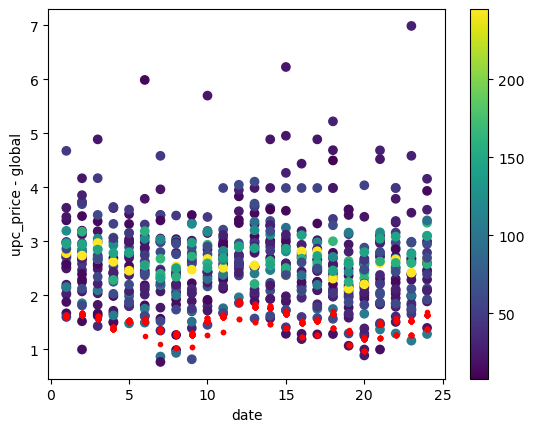

In [21]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

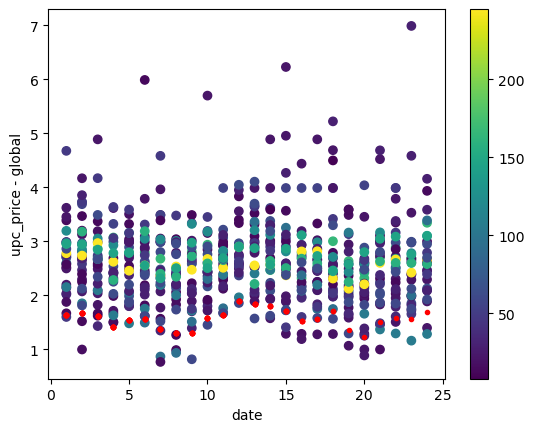

In [22]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_ni, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

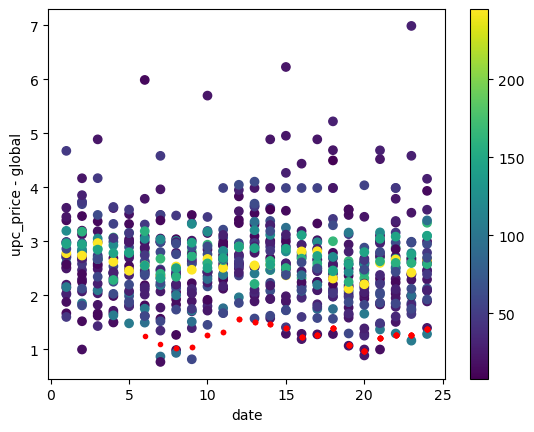

In [23]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

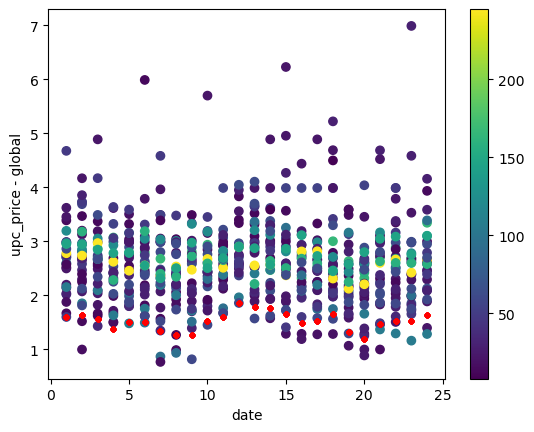

In [24]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_c, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

In [25]:
new.groupby("date")["fitted_value"].nunique()

date
1     2
2     2
3     2
4     2
5     2
6     3
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
19    3
20    3
21    3
22    3
23    3
24    3
Name: fitted_value, dtype: int64

#### 2.2. For control group

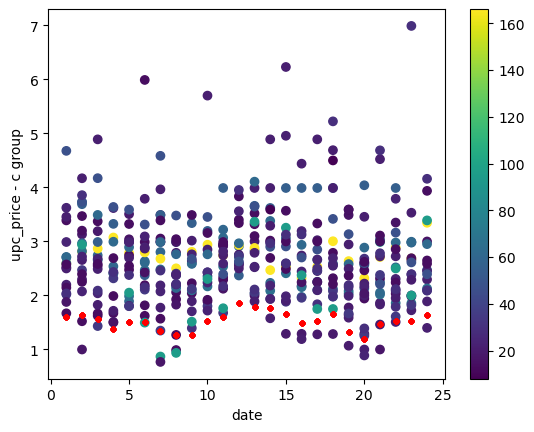

In [26]:
plt.scatter('date','upc_price', data = new_c, c=new_c['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_c, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - c group')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

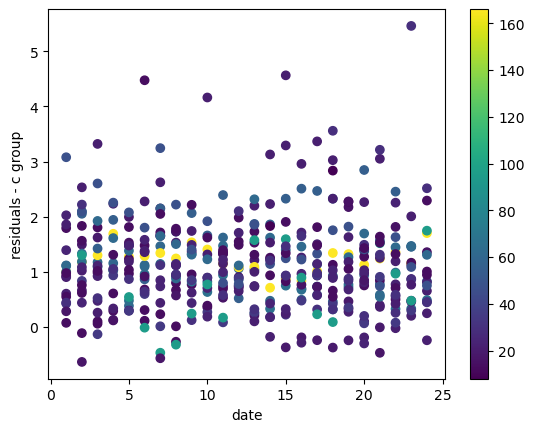

In [27]:
plt.scatter('date','residual', data = new_c, c=new_c['Population density (people/km^2)'].astype(int).to_numpy())
#plt.plot('date','fitted_value', data = new_c, color='red', marker='.', linestyle='')
plt.ylabel('residuals - c group')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

#### 2.3. For treatment group before entry

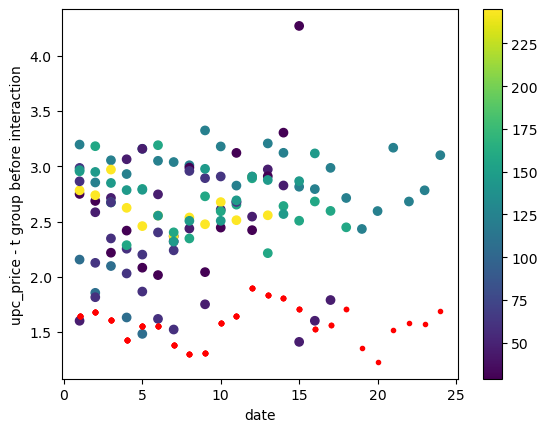

In [28]:
plt.scatter('date','upc_price', data = new_t_ni, c=new_t_ni['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_ni, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - t group before interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

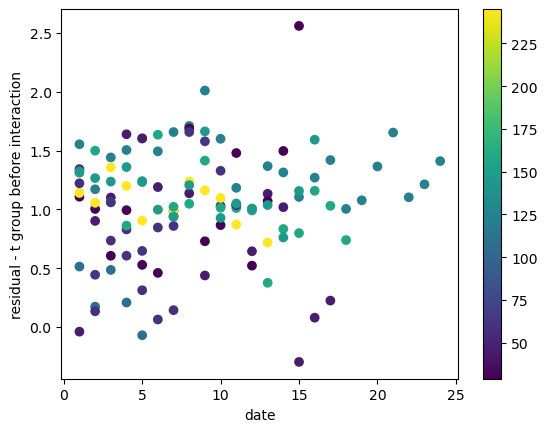

In [29]:
plt.scatter('date','residual', data = new_t_ni, c=new_t_ni['Population density (people/km^2)'].astype(int).to_numpy())
#plt.plot('date','fitted_value', data = new_t_ni, color='red', marker='.', linestyle='')
plt.ylabel('residual - t group before interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

#### 2.4. For treatment group after entry

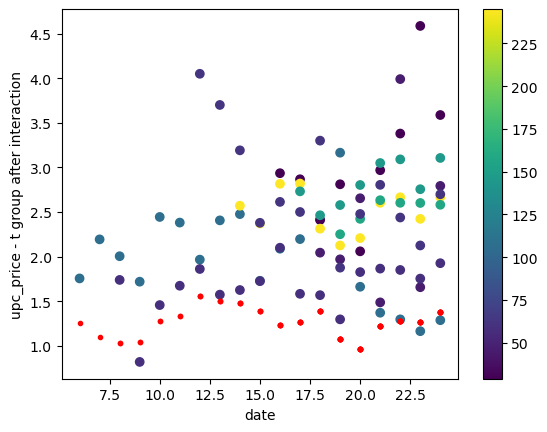

In [30]:
plt.scatter('date','upc_price', data = new_t_i, c=new_t_i['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - t group after interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

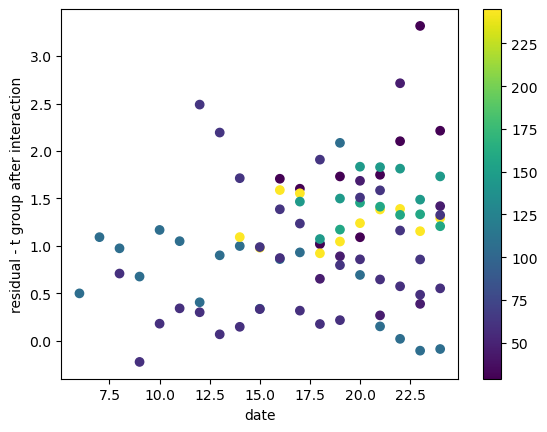

In [31]:
plt.scatter('date','residual', data = new_t_i, c=new_t_i['Population density (people/km^2)'].astype(int).to_numpy())
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('residual - t group after interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

### 3. Identifying counties for which residuals (aggregated SSR) are maximal/minimal

#### 3.1. Counties sorted by aggregated SSR

In [40]:
df_SSR = new.groupby(['store_state', 'guessed_store_county',
       'guessed_store_county_fips']).mean()
df_SSR['SSR']=np.sqrt(df_SSR['s_residual'])
df_SSR = df_SSR[['SSR']].sort_values(by=["SSR"])
df_SSR.head(50)

C:\Users\inesn\AppData\Local\Temp\ipykernel_37980\1524736469.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'guessed_store_county_fips']).mean()


SSR
store_state guessed_store_county guessed_store_county_fips          
SC          COLLETON             45029                      0.528565
            GREENWOOD            45047                      0.530358
            KERSHAW              45055                      0.567991
            SALUDA               45081                      0.588263
            ANDERSON             45007                      0.803826
            FLORENCE             45041                      0.811665
            MARION               45067                      0.866464
            PICKENS              45077                      0.950171
            UNION                45087                      0.996669
            AIKEN                45003                      1.051233
            ORANGEBURG           45075                      1.052687
            CLARENDON            45027                      1.065008
            DARLINGTON           45031                      1.113081
            CHESTERFIELD         45025                      1.120211
            BAMBERG              45009                      1.124735
            ABBEVILLE            45001                      1.150193
            LEXINGTON            45063                      1.156839
            GREENVILLE           45045                      1.159392
            CALHOUN              45017                      1.179374
            JASPER               45053                      1.226680
            MARLBORO             45069                      1.227744
            CHARLESTON           45019                      1.239329
            NEWBERRY             45071                      1.273930
            HAMPTON              45049                      1.335456
            YORK                 45091                      1.348022
            SUMTER               45085                      1.364937
            BEAUFORT             45013                      1.407030
            LANCASTER            45057                      1.443194
            GEORGETOWN           45043                      1.523182
            WILLIAMSBURG         45089                      1.588929
            OCONEE               45073                      1.807311
            CHEROKEE             45021                      1.980124
            BARNWELL             45011                      2.273291
            ALLENDALE            45005                      2.348933
            CHESTER              45023                      2.602426
            DILLON               45033                      2.648214

In [45]:
df_n = pd.merge(df_SSR, new, on = ['store_state', 'guessed_store_county',
       'guessed_store_county_fips'])
df_n = df_n.sort_values(by=['SSR'])
df_n.head(60)

,store_state,guessed_store_county,guessed_store_county_fips,SSR,upc_price,nb_of_obs,Population density (people/km^2),treat,interaction,time_effects,Opening_date,Closing_date,fitted_value,residual,date,s_residual
0,SC,COLLETON,45029,0.528565,2.145000,2,13.729634,False,False,"(2015, 1)",NaT,NaT,1.598865,0.546135,1,0.298263
1,SC,COLLETON,45029,0.528565,2.252000,5,13.729634,False,False,"(2015, 2)",NaT,NaT,1.638333,0.613667,2,0.376588
2,SC,COLLETON,45029,0.528565,1.625000,2,13.729634,False,False,"(2015, 3)",NaT,NaT,1.569669,0.055331,3,0.003062
3,SC,COLLETON,45029,0.528565,1.806667,6,13.729634,False,False,"(2015, 5)",NaT,NaT,1.512370,0.294297,5,0.086610
4,SC,COLLETON,45029,0.528565,2.190000,2,13.729634,False,False,"(2015, 6)",NaT,NaT,1.513834,0.676166,6,0.457201
5,SC,COLLETON,45029,0.528565,1.570000,2,13.729634,False,False,"(2015, 7)",NaT,NaT,1.341346,0.228654,7,0.052282
6,SC,COLLETON,45029,0.528565,2.060000,1,13.729634,False,False,"(2015, 8)",NaT,NaT,1.261938,0.798062,8,0.636904
7,SC,COLLETON,45029,0.528565,1.890000,2,13.729634,False,False,"(2015, 10)",NaT,NaT,1.536671,0.353329,10,0.124841
8,SC,COLLETON,45029,0.528565,2.290000,1,13.729634,False,False,"(2015, 11)",NaT,NaT,1.598137,0.691863,11,0.478674
24,SC,GREENWOOD,45047,0.530358,2.099444,18,59.660420,True,True,"(2016, 4)",2015-07-01,NaT,1.227673,0.871771,16,0.759985


####  3.2. Impact of density on aggregated SSR

Text(0.5, 0, 'Density')

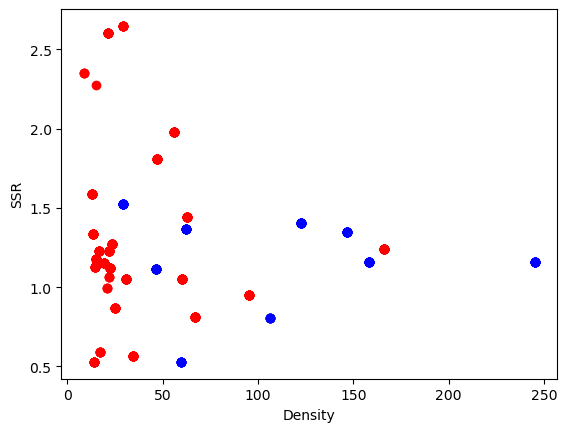

In [42]:
plt.scatter('Population density (people/km^2)','SSR', data = df_n[~df_n.treat], c='red')
plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(~df_n.interaction)], c='blue')
#plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(df_n.interaction)], c='yellow', marker = '.')
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('SSR')
plt.xlabel('Density')
#plt.xlim(445,455)df_n['treat'].astype(int).to_numpy()

####  3.3. Impact of price on aggregated SSR ??? Not relevant ?

Text(0.5, 0, 'upc_price')

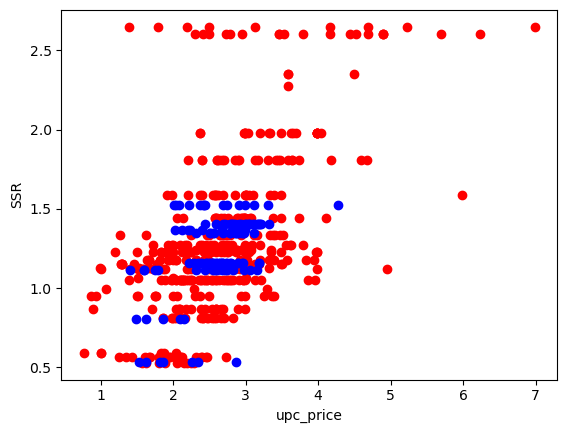

In [43]:
plt.scatter('upc_price','SSR', data = df_n[~df_n.treat], c='red')
plt.scatter('upc_price','SSR', data = df_n[(df_n.treat)&(~df_n.interaction)], c='blue')
#plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(df_n.interaction)], c='yellow', marker = '.')
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('SSR')
plt.xlabel('upc_price')
#plt.xlim(445,455)df_n['treat'].astype(int).to_numpy()

#### 3.4. Impact of the number of observations on aggregated SSR

Text(0.5, 0, 'nb_of_obs')

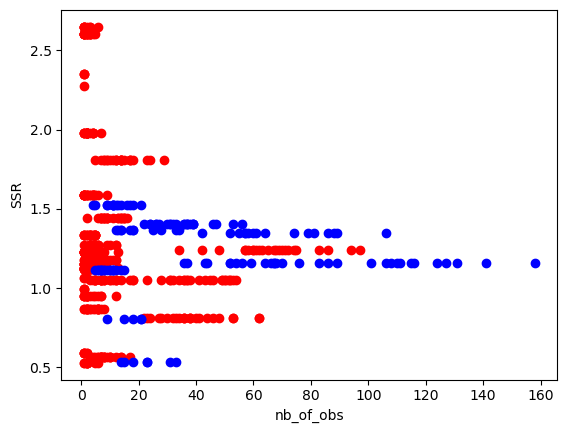

In [44]:
plt.scatter('nb_of_obs','SSR', data = df_n[~df_n.treat], c='red')
plt.scatter('nb_of_obs','SSR', data = df_n[(df_n.treat)&(~df_n.interaction)], c='blue')
#plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(df_n.interaction)], c='yellow', marker = '.')
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('SSR')
plt.xlabel('nb_of_obs')
#plt.xlim(445,455)df_n['treat'].astype(int).to_numpy()